Q1-using sklearn, extract test set

In [151]:
import numpy as np 
np.set_printoptions(precision=3)
import pandas as pd
pd.set_option('display.precision',3)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
real = pd.read_csv('real.csv', index_col=0) #1열부터 시작
real.columns = ['date','house_age','dist_mrt','no_cvs','lat','long','price']
real.info()
real.sort_values(by=['price'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       414 non-null    float64
 1   house_age  414 non-null    float64
 2   dist_mrt   414 non-null    float64
 3   no_cvs     414 non-null    int64  
 4   lat        414 non-null    float64
 5   long       414 non-null    float64
 6   price      414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


In [153]:
real['date'] = pd.Series([str(x)[:4] for x in real['date']]).astype('category')#date 변수를 year 변수로 

In [154]:
real['year'] = real['date']
real.drop(['date'], axis=1, inplace=True)
real = pd.get_dummies(real) # get_dummies를 사용하면 문자열 특성만 인코딩 되며 숫자 특성은 바뀌지 않는다.

real.head() 

,house_age,dist_mrt,no_cvs,lat,long,price,year_2012,year_2013
No,,,,,,,,
114,14.8,393.261,6,24.962,121.538,7.6,0,1
348,17.4,6488.021,1,24.957,121.474,11.2,0,1
163,16.0,4066.587,0,24.943,121.503,11.6,1,0
117,30.9,6396.283,1,24.944,121.479,12.2,0,1
331,32.0,1156.777,0,24.949,121.530,12.8,0,1


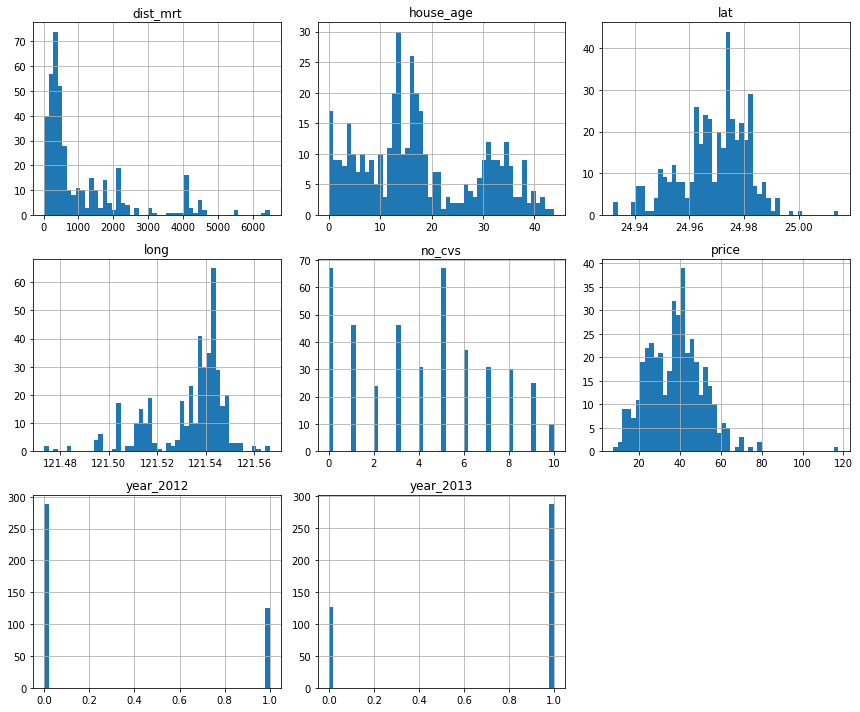

In [155]:
real.hist(bins=50, figsize=(12,10))
plt.tight_layout()

In [156]:
np.percentile(real.price, 99.5)

77.71400000000001

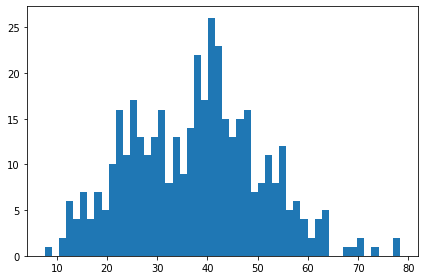

In [157]:
real = real[real.price < 80] #outlier 하나 제거
plt.hist(real.price, bins=50)
plt.tight_layout()

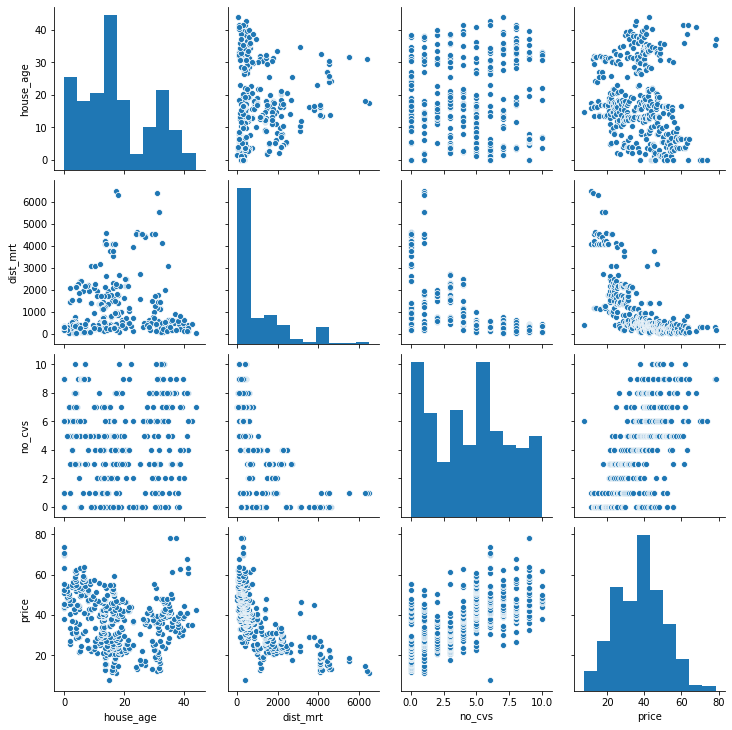

In [158]:
sns.pairplot(real[['house_age', 'dist_mrt','no_cvs','price']])

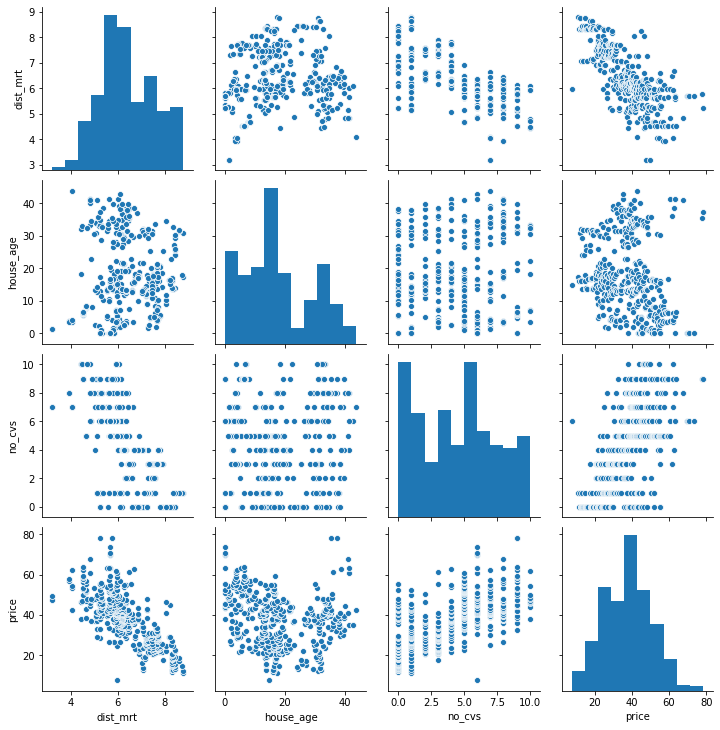

In [159]:
real2 = real.copy()
real2['dist_mrt'] = np.log(1+real.dist_mrt) # to prevent inf
sns.pairplot(real2[['dist_mrt', 'house_age','no_cvs','price']])

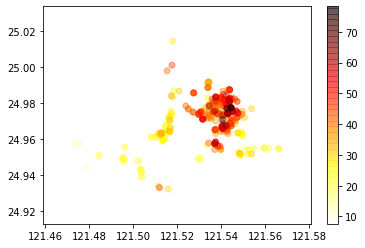

In [160]:
fig, ax = plt.subplots()
scatter = ax.scatter(real2.long, real2.lat, 
            c=real2.price, cmap='hot_r', alpha=0.4)
fig.colorbar(scatter)

Q1: train/test split

In [161]:
data = real2[['year_2012','year_2013', 'dist_mrt', 'house_age', 'no_cvs', 'price']]

In [162]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=413)
print(train.shape)
print(test.shape)

(330, 6)
(83, 6)


In [163]:
X_train=train.iloc[:,range(0,5)]
y_train=train.iloc[:,[5]]
X_test=test.iloc[:,range(0,5)]
y_test=test.iloc[:,[5]]

Feature scaling

In [164]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

def Scl_train(sclr, df):
    colnames = df.columns
    df = sclr.transform(df)
    df = pd.DataFrame(df)
    df.set_axis(colnames, axis=1, inplace=True)
    return df

In [165]:
X_train_sc = Scl_train(scaler, X_train)
X_test_sc = Scl_train(scaler, X_test)

X_test_sc.describe()

,year_2012,year_2013,dist_mrt,house_age,no_cvs
count,83.000,83.000,83.000,83.000,83.000
mean,-0.011,0.017,-0.022,0.114,0.029
std,1.002,0.999,1.041,1.058,1.075
min,-0.664,-1.495,-2.896,-1.552,-1.408
25%,-0.664,-1.495,-0.672,-0.779,-1.064
50%,-0.664,0.669,-0.105,-0.095,0.316
75%,1.506,0.669,0.778,1.077,1.005
max,1.506,0.669,1.820,2.126,2.040


Q2-Polynomial basis Feature Extraction: X를 Phi로

In [166]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px

In [167]:
def Poly_Reg(X_train, Y_train, X_test, Y_test, m, fig=False):
    # Feature Extraction
    poly = PolynomialFeatures(degree=m)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    # LR Fitting # 선형회귀로 피팅
    lin = LinearRegression(fit_intercept=False)
    lin.fit(X_train_poly, Y_train)
    Y_train_pred = lin.predict(X_train_poly)
    Y_test_pred = lin.predict(X_test_poly)

    # Compue MSE
    train_MSE = np.sqrt(np.linalg.norm(Y_train - Y_train_pred)**2/Y_train.shape[0])
    test_MSE = np.sqrt(np.linalg.norm(Y_test - Y_test_pred)**2/Y_test.shape[0])

    # Visualize
    if fig is True:
        fig = px.scatter_3d(x=X_train.dist_mrt, y=X_train.house_age, z=Y_train_pred)
        fig.update_traces(marker=dict(size=4,
                                  line=dict(width=0.1,
                                            color='DarkSlateGrey')))
        fig.show()
    
    # Residual
    Resid = Y_train - Y_train_pred
    
    return {'coef':lin.coef_, 'train_MSE':train_MSE, 'test_MSE':test_MSE, 'Resid':Resid}

In [168]:
PRmodel = Poly_Reg(X_train_sc, y_train, X_test_sc, y_test, 2, fig=False)
PRmodel

{'coef': array([[-4.607e+13,  7.845e+12,  4.463e+13,  1.185e+11,  1.171e+11,
         -5.334e+10, -1.000e+14, -9.753e+12, -1.801e+13, -1.781e+13,
          8.112e+12,  1.368e+14, -1.806e+13, -1.786e+13,  8.134e+12,
         -3.217e+00,  1.790e+00, -3.087e+00,  2.119e+00,  7.101e-01,
         -1.460e+00]]),
 'train_MSE': 7.332322199027021,
 'test_MSE': 7.809255193063709,
 'Resid':      price
 No        
 239  5.635
 315 -3.697
 100  5.700
 66  -3.770
 182  7.447
 ..     ...
 200 -7.658
 370 -4.298
 85   0.856
 191  1.136
 262  0.673
 
 [330 rows x 1 columns]}

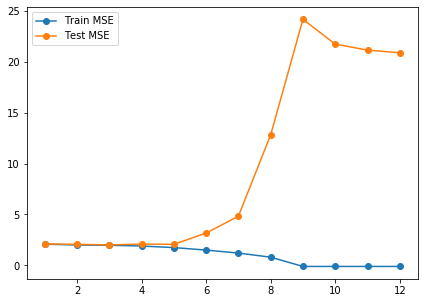

In [169]:
output = pd.DataFrame(columns=['d','Train MSE','Test MSE'])

for i in np.arange(12):
    m = i+1
    Reg = Poly_Reg(X_train_sc, y_train, X_test_sc, y_test, m, fig=False)
    output.loc[i] = [m, Reg['train_MSE'], Reg['test_MSE']]


fig, ax = plt.subplots(figsize=(7,5))
ax.plot(output['d'], np.log(output['Train MSE']), 'o-', label='Train MSE')
ax.plot(output['d'], np.log(output['Test MSE']), 'o-', label='Test MSE')

ax.legend()

Q3-Ridge/Lasso Reg

Ridge

In [180]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
alphas=np.logspace(-3, 3, 300)
#alpha 낮게 = 규제 약하게 = overfitting 방향
#alpha 높게 = 규제 강하게 = underfitting 방향

poly = PolynomialFeatures(degree=2)
Phi_train = poly.fit_transform(X_train_sc)
Phi_test = poly.fit_transform(X_test_sc)
print(Phi_train.shape)
print(Phi_test.shape)

(330, 21)
(83, 21)


In [181]:
def Ridge_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Ridge?##
    #1. Call Ridge function as an object
    reg = Ridge()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
        
    lam=alphas[np.argmin(test_MSE)]
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()
        

        print("Weight:" ,coefs[np.argmin(test_MSE)], "lambda:" ,lam)
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE, 'lambda': lam}

Weight: [[ 0.    -0.016 -0.566 -7.119 -3.236  1.934 -0.014  0.4    0.747  0.613
  -0.516  0.468  0.199 -0.065 -0.459 -2.596  1.495 -1.954  2.012  0.398
  -0.985]] lambda: 10.80052374516254


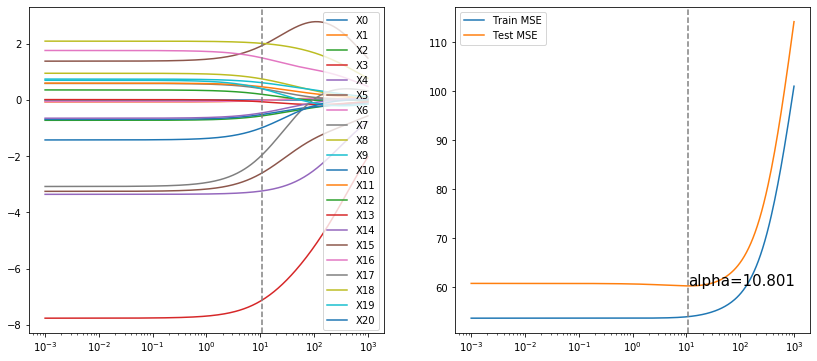

In [182]:
Ridge_output = Ridge_Reg(Phi_train, y_train, Phi_test, y_test, alphas, fig=True)

In [183]:
Ridge_output['lambda']

10.80052374516254

Lasso

In [184]:
from sklearn.linear_model import Lasso
alphas=np.logspace(-6, 6, 500)

In [185]:
def Lasso_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Lasso?##
    #1. Call Lasso function as an object
    reg = Lasso()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
    
    lam=alphas[np.argmin(test_MSE)]
    
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()
    

        print("Weight:" ,coefs[np.argmin(test_MSE)], "lambda:" ,lam)
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE, 'lambda': lam}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.9636699046623, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.9639090578366, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.9641619459799, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.9644292265493, to

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.9902499985728, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.9919986670266, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.993846456755, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.9957989636023, tol

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1541.23673334673, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1541.2522012954141, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1541.268512667224, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1541.2857111309331, toler

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.56167542293406, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.6222140301088, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.68612663403655, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.75359680939073, tol

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.524075239209196, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.604820281245338, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.689802250042703, tolerance: 5.474189563636364

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.77922018370009, tol

Weight: [ 0.     0.    -0.562 -7.535 -3.249  1.642  0.     0.     0.562  0.608
 -0.     0.    -0.    -0.     0.    -2.656  1.319 -2.07   1.964  0.219
 -0.926] lambda: 0.07206351321293045


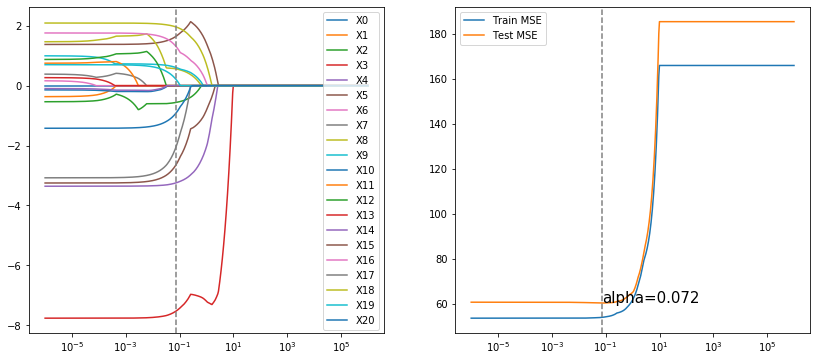

In [186]:
Lasso_output = Lasso_Reg(Phi_train, y_train, Phi_test, y_test, alphas, fig=True)

In [187]:
Lasso_output['lambda']

0.07206351321293045

Ridge가 완만하게 계수를 조진다면, Lasso는 화끈하게 쳐내버리는 것을 볼 수 있다

Q4: k-fold CV for  𝜆

In [188]:
import numpy as np
from sklearn.model_selection import KFold

kcv = KFold(n_splits=5)

kcvMSE_Ridge = np.zeros((kcv.get_n_splits(), alphas.size))
kcvMSE_Lasso = np.zeros((kcv.get_n_splits(), alphas.size))

i = 0
for train_index, test_index in kcv.split(Phi_train, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    CV_Phi_train, CV_Phi_test = Phi_train[train_index,:], Phi_train[test_index,:]
    CV_y_train, CV_y_test = y_train.iloc[train_index,:], y_train.iloc[test_index,:]
    
    Ridge_output = Ridge_Reg(CV_Phi_train, CV_y_train, CV_Phi_test, CV_y_test, alphas, fig=False)
    kcvMSE_Ridge[i, :] = Ridge_output['test_MSE']
    
    Lasso_output = Lasso_Reg(CV_Phi_train, CV_y_train, CV_Phi_test, CV_y_test, alphas, fig=False)
    kcvMSE_Lasso[i, :] = Lasso_output['test_MSE']
    i += 1

TRAIN: [ 66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 426.7759185636569, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 426.7760584460266, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 426.77620685559486, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 426.7763619323996, toler

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.3564481150697, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.3580156887965, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.35967131408324, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.36142010664116, tole

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.3580106702284, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.9979873401262, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 273.4509950690335, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 273.4829332132831, tolera

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.4974806283426, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.56186390368566, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.6297863726686, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.70144760268886, tole

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.14287871634042, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.221284895389545, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.303706788956333, tolerance: 4.352763318181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.390343215762186, tol

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.7826043350042, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.782805000461, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.7830157505432, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.7832385216107, tol

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.8111823438621, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.8130046706765, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.8149302729971, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.8169648217608, to

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1197.1775060591362, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1197.1994471659218, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1197.2225505503984, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1197.246872208465, tol

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.23549786924013, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.32421785560837, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.41781729995637, tolerance: 4.383699757575758

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.5165599009415, tol

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.2575577298903, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.257722888151, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.2578985245673, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.2580836417437, toleran

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.2957252746219, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.67788383059997, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.29115969242412, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.29273795618974, tol

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.30430236237407, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.34549776970016, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.38900838789232, tolerance: 4.277777359848485

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.43496696629518, to

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2499.3125522680466, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2499.3128324746094, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2499.3131284466954, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2499.3134410968532, to

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.285129194428, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.2863455718507, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.2876306586786, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.2889883030293, toleran

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.3876932798121, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 610.6283279990585, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.1213018584185, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.1331357715007, tolera

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 346.98705785319726, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.0250135333481, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.06489159746525, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.1067502752485, tole

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.132275924162968, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.223143528064611, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.318619548585048, tolerance: 4.456135693181818

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.418896655863136, to

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.9319032905523, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.9322191920974, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.932552478149, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.9329048982163, tolera

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.9607717870313, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.9627269613684, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.9647930748724, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.966976264507, tolera

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2618.1500219859627, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2618.162581168165, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2618.175834908954, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2618.1898203658475, toleran

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.80707399620587, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.83023431069523, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.85470209654886, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.8805504959164, tolera

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.32325464173118, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.48463094222097, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.6545935604663, tolerance: 4.40911053030303

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.900388352139998, tolera

Weight: [[ 0.    -0.015 -0.646 -7.24  -3.311  1.714 -0.012  0.451  0.48   0.749
  -0.827  0.534  0.598 -0.125 -0.283 -3.176  1.895 -2.71   2.068  0.864
  -1.181]]


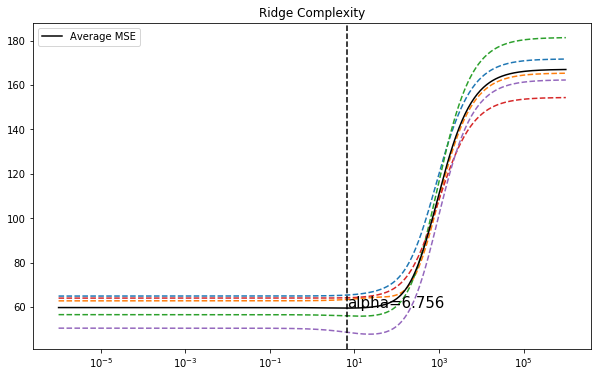

In [189]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE1 = np.apply_along_axis(np.mean, 1, kcvMSE_Ridge.T)
ax.plot(alphas, kcvMSE_Ridge.T, linestyle='--')
ax.plot(alphas, meanMSE1, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE1)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE1)],3)
ax.text(alphas[np.argmin(meanMSE1)], np.amin(meanMSE1), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Ridge Complexity')
ax.legend()

coefs = Ridge_output['coefs']
print("Weight:" ,coefs[np.argmin(meanMSE1)])

Weight: [ 0.     0.    -0.624 -7.567 -3.199  1.534  0.    -0.     0.     0.723
 -0.374  0.     0.    -0.     0.    -2.76   1.369 -2.063  1.976  0.321
 -0.78 ]


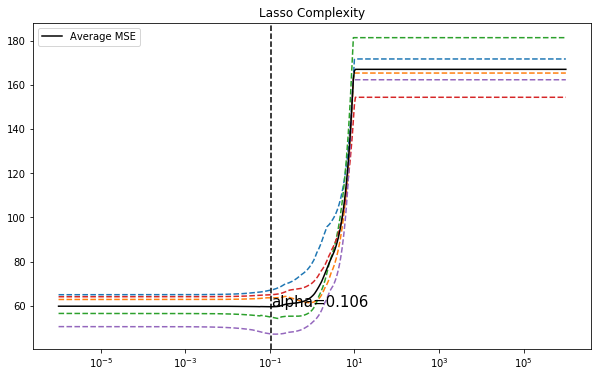

In [190]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE2 = np.apply_along_axis(np.mean, 1, kcvMSE_Lasso.T)
ax.plot(alphas, kcvMSE_Lasso.T, linestyle='--')
ax.plot(alphas, meanMSE2, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE2)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE2)],3)
ax.text(alphas[np.argmin(meanMSE2)], np.amin(meanMSE2), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Lasso Complexity')
ax.legend()

coefs = Lasso_output['coefs']
print("Weight:" ,coefs[np.argmin(meanMSE2)])

Q5:최종적으로 test MSE 보고 후, 어떤 feature가 선택되었으며, 왜 그랬는지 설명해보기

In [195]:
rdg1=Ridge(alpha=alphas[np.argmin(meanMSE1)])
rdg1.fit(Phi_train, y_train)
print(rdg1.coef_)

rdg2=Ridge(alpha=Ridge_output['lambda'])
rdg2.fit(Phi_train, y_train)
print(rdg2.coef_)

[[ 0.    -0.032 -0.613 -7.326 -3.281  1.766 -0.027  0.456  0.808  0.652
  -0.568  0.507  0.245 -0.043 -0.516 -2.794  1.573 -2.294  2.039  0.489
  -1.117]]
[[ 0.     0.015 -0.47  -6.647 -3.111  2.274  0.012  0.29   0.62   0.533
  -0.416  0.388  0.113 -0.108 -0.342 -2.188  1.345 -1.261  1.945  0.218
  -0.716]]


In [196]:
pred1=rdg1.predict(Phi_test)
rmse1 = np.sqrt(mean_squared_error(y_test, pred1))
print(rmse1)

pred2=rdg2.predict(Phi_test)
rmse2=np.sqrt(mean_squared_error(y_test, pred2))
print(rmse2)

7.767547640883511
7.781717248202373


In [197]:
lso1=Lasso(alpha=alphas[np.argmin(meanMSE2)])
lso1.fit(Phi_train, y_train)
print(lso1.coef_)

lso2=Lasso(alpha=Lasso_output['lambda'])
lso2.fit(Phi_train, y_train)
print(lso2.coef_)

[ 0.000e+00  0.000e+00 -5.289e-01 -7.414e+00 -3.193e+00  1.766e+00
  0.000e+00 -0.000e+00  5.239e-01  5.487e-01 -0.000e+00  0.000e+00
 -0.000e+00 -0.000e+00  0.000e+00 -2.368e+00  1.104e+00 -1.570e+00
  1.901e+00  4.631e-04 -6.986e-01]
[ 0.     0.    -0.504 -7.336 -3.155  1.831  0.    -0.     0.497  0.529
 -0.     0.    -0.    -0.     0.    -2.206  1.059 -1.296  1.853  0.
 -0.584]


In [198]:
pred3=lso1.predict(Phi_test)
rmse3 = np.sqrt(mean_squared_error(y_test, pred3))
rmse3 
print(rmse3)

pred4=lso2.predict(Phi_test)
rmse4 = np.sqrt(mean_squared_error(y_test, pred4))
rmse4 
print(rmse4)

7.779006838108593
7.7798952196764395
